# Lowman Coherence

This is the start of my exploration of what coherence looks like for the Lowman site in Idaho. 

In [2]:
from pathlib import Path
from datetime import datetime
from time import time

import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import tifffile as tif

from uavsar_pytools.convert.tiff_conversion import read_annotation
from uavsar_pytools.georeference import geolocate_uavsar

/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import my custom modules. 
I had to import specific functions from my files, otherwise I was getting an error. 

In [3]:
import sys
import os

scripts_dir = (os.path.dirname(os.getcwd()) + '/scripts/')
sys.path.append(scripts_dir)

from plotting import plot_tifs_grid 
from coherence import calc_coherence_unweighted

## Load Data 

This data is already downloaded and in a data/ directory in this repository. 

In [214]:
slc_dir = "../data/data/snowex_lowman/slcs/"
data_dir = "../data/data/snowex_lowman/"
in_dir = Path(slc_dir)
slcs_05208 = sorted(list(in_dir.glob('*05208*.slc')))
anns_05208 = sorted(list(in_dir.glob('*05208*.ann')))
slcs_23205 = sorted(list(in_dir.glob('*23205*.slc')))
anns_23205 = sorted(list(in_dir.glob('*23205*.ann')))

In [5]:
d5 = read_annotation(anns_05208[0])
d5 = pd.DataFrame(d5).T
rows, cols = d5.loc['slc_2_2x8 rows', 'value'], d5.loc['slc_2_2x8 columns', 'value']
stack5 = np.zeros((len(slcs_05208), rows, cols), '<c8')
dates5 = []
for i, (slc, ann) in enumerate(zip(slcs_05208, anns_05208, strict = True)):
    print(slc)
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']

    
    stack5[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
    dates5.append(timestamp)

../data/data/snowex_lowman/slcs/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20007_002_200213_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20011_002_200221_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_20016_003_200311_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21009_005_210203_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21012_004_210210_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21015_009_210303_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21017_019_210310_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21019_019_210316_L090VV_01_BU_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_05208_21021_007_210322_L090VV_01_BU_s2_2x8.slc


In [195]:
d2 = read_annotation(anns_23205[0])
d2 = pd.DataFrame(d2).T
rows, cols = d2.loc['slc_2_2x8 rows', 'value'], d2.loc['slc_2_2x8 columns', 'value']
stack2 = np.zeros((len(slcs_23205), rows, cols), '<c8')
dates2 = []
for i, (slc, ann) in enumerate(zip(slcs_23205, anns_23205, strict = True)):
    print(slc)
    d = read_annotation(ann)
    d = pd.DataFrame(d).T
    timestamp = d.loc['start time of acquisition', 'value']

    
    stack2[i, :, :] = np.fromfile(slc, '<c8').reshape(rows, cols)
    dates2.append(timestamp)

../data/data/snowex_lowman/slcs/lowman_23205_20002_007_200131_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20007_003_200213_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20011_003_200221_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_20016_004_200311_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21002_004_210115_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21004_003_210120_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21008_000_210127_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21009_004_210203_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21012_000_210210_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21015_008_210303_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21017_018_210310_L090VV_01_BC_s2_2x8.slc
../data/data/snowex_lowman/slcs/lowman_23205_21019_018

In [196]:
print(len(stack2))
print(np.shape(stack2))
print(dates2)

13
(13, 8333, 4427)
[Timestamp('2020-01-31 14:30:06-0700', tz='US/Mountain'), Timestamp('2020-02-13 13:47:36-0700', tz='US/Mountain'), Timestamp('2020-02-20 18:53:09-0700', tz='US/Mountain'), Timestamp('2020-03-11 11:45:38-0600', tz='US/Mountain'), Timestamp('2021-01-15 12:50:41-0700', tz='US/Mountain'), Timestamp('2021-01-20 14:20:34-0700', tz='US/Mountain'), Timestamp('2021-01-27 16:54:34-0700', tz='US/Mountain'), Timestamp('2021-02-03 12:54:53-0700', tz='US/Mountain'), Timestamp('2021-02-10 15:20:37-0700', tz='US/Mountain'), Timestamp('2021-03-03 11:08:14-0700', tz='US/Mountain'), Timestamp('2021-03-10 10:42:49-0700', tz='US/Mountain'), Timestamp('2021-03-16 11:49:32-0600', tz='US/Mountain'), Timestamp('2021-03-22 10:39:36-0600', tz='US/Mountain')]


In [19]:
print(dates2[0:8])

[Timestamp('2020-01-31 14:30:06-0700', tz='US/Mountain'), Timestamp('2020-02-13 13:47:36-0700', tz='US/Mountain'), Timestamp('2020-02-20 18:53:09-0700', tz='US/Mountain'), Timestamp('2020-03-11 11:45:38-0600', tz='US/Mountain'), Timestamp('2021-01-15 12:50:41-0700', tz='US/Mountain'), Timestamp('2021-01-20 14:20:34-0700', tz='US/Mountain'), Timestamp('2021-01-27 16:54:34-0700', tz='US/Mountain'), Timestamp('2021-02-03 12:54:53-0700', tz='US/Mountain')]


## Calculating the coherence
Calculating the coherence in a loop for the 10 lowman 05208 files took 30 seconds per pair for 45 total pair combinations. After doing this once, I saved all of those output into one big .tif file with 45 layers. 

This file is 14 GB but loads pretty quickly using the tifffile module. 

In [7]:
print(stack2.shape)

(13, 8333, 4427)


In [167]:
# stack = stack2
# pairs = []
# for i in range(len(stack)) : 
#     for j in range(len(stack)) : 
#         # if (j > 2) : 
#         #     break
#         if (i >= j) : 
#             continue
#         start_time = time()
#         print(f"calculating coherence for img {i} and img {j}")
#         pairs.append(calc_coherence_unweighted(stack[i], stack[j]))
#         end_time = time()
#         elapsed_time = end_time - start_time
#         print(f"   elapsed time: {elapsed_time} seconds")

# c2 = np.stack(pairs, axis=0)

### OR 
# c5 = tif.imread(data_dir + 'lowman_05208_coherences.stack')
c2 = tif.imread(data_dir + 'lowman_23205_coherences.stack')

The follwing lines should be executed if you used the above code to generate new coherences, and need to save that to a file. 

In [ ]:
print(c2.shape)
# tif.imwrite(data_dir + 'lowman_05208_coherences.stack', c5, bigtiff=True)
tif.imwrite(data_dir + 'lowman_23205_coherences.stack', c2, bigtiff=True)

(78, 8333, 4427)


In [168]:
plot_tifs_grid(np.abs(stack2[0:len(dates5) :, :]), is_file=False)

NameError: name 'stack2' is not defined

At this stage, I should have a stack of coherences between every image pair. For all 10 images, this will be 45 image pairs. 

Next I want to calculate average coherence for each image pair and make it into a coherence matrix, like Zach suggests. 
This step takes a couple of minutes to calculate for all 45 image pairs (current run: 50s)

In [170]:
stack = stack2
coh = c2
print(coh.shape)


avgs = np.zeros([len(stack), len(stack)])
counter = 0
for i in range(len(stack)) : 
    for j in range(i, len(stack)) : 
        if (i == j) : 
            avgs[i, j] = 1
            continue
        avgs[i, j] = np.mean(coh[counter])
        counter += 1

(78, 8333, 4427)


In [172]:
print([avgs, dates5])
avgs_nan = np.where(avgs == 0, np.nan, avgs)
print(avgs_nan)

[array([[1.        , 0.26031557, 0.24321035, 0.17261904, 0.15278551,
        0.14975773, 0.14091817, 0.14348356, 0.15312266, 0.14269824,
        0.13329604, 0.1347619 , 0.13139565],
       [0.        , 1.        , 0.51421553, 0.30595011, 0.18128896,
        0.18126822, 0.14984089, 0.14698721, 0.2026169 , 0.18501039,
        0.16152437, 0.17210808, 0.14960991],
       [0.        , 0.        , 1.        , 0.31649324, 0.18563344,
        0.19204824, 0.16240062, 0.15574932, 0.20518993, 0.19128335,
        0.16794123, 0.17365797, 0.15874906],
       [0.        , 0.        , 0.        , 1.        , 0.17417733,
        0.17649128, 0.13929886, 0.13615954, 0.18391198, 0.19212538,
        0.1852712 , 0.2180367 , 0.18227603],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.68205291, 0.39212054, 0.25026941, 0.34064382, 0.29475662,
        0.25169709, 0.24834032, 0.22783864],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.4799

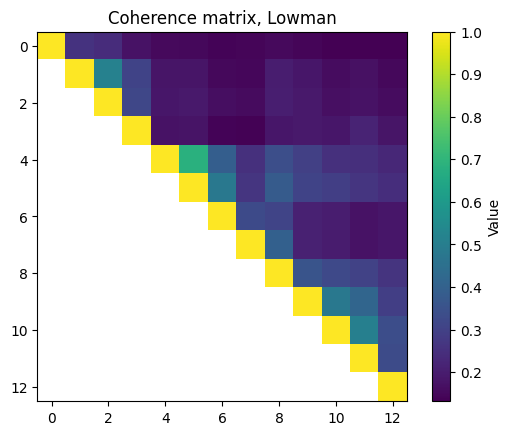

In [173]:
plt.imshow(avgs_nan, cmap='viridis', origin='lower') 
plt.colorbar(label='Value')
plt.title('Coherence matrix, Lowman')
plt.gca().invert_yaxis()
# plt.grid(True, color='white', linewidth=0.5)
plt.show()

This plot shows the coherences between image pairs for all the 2020 and 2021 UAVSAR images. The coherence between image 5 and anything less is virutually 0, because those represent a different winter season. 

In [9]:
print(dates5)

[Timestamp('2020-01-31 14:10:44-0700', tz='US/Mountain'), Timestamp('2020-02-13 13:27:17-0700', tz='US/Mountain'), Timestamp('2020-02-20 18:34:39-0700', tz='US/Mountain'), Timestamp('2020-03-11 11:25:50-0600', tz='US/Mountain'), Timestamp('2021-02-03 13:16:28-0700', tz='US/Mountain'), Timestamp('2021-02-10 16:06:16-0700', tz='US/Mountain'), Timestamp('2021-03-03 11:28:34-0700', tz='US/Mountain'), Timestamp('2021-03-10 11:03:07-0700', tz='US/Mountain'), Timestamp('2021-03-16 12:09:25-0600', tz='US/Mountain'), Timestamp('2021-03-22 10:58:31-0600', tz='US/Mountain')]


In [174]:
dates = dates2

time_dif = np.full((len(dates), len(dates)), np.nan)
counter = 0
for i in range(len(dates)) : 
    for j in range(i, len(dates)) : 
        if (i == j) : 
            time_dif[i, j] = np.nan
            continue
        timedelt = pd.to_datetime(dates[j]) - pd.to_datetime(dates[i])
        time_dif[i, j] = timedelt.total_seconds() / (24 * 60 * 60)
        counter += 1
print(time_dif)
# time_dif = np.where(time_dif > 50, np.nan, time_dif)

[[         nan  12.97048611  20.18267361  39.84412037 349.93096065
  354.99337963 362.10032407 368.93387731 376.03508102 396.85981481
  403.84216435 409.8468287  415.79826389]
 [         nan          nan   7.2121875   26.87363426 336.96047454
  342.02289352 349.12983796 355.9633912  363.06459491 383.8893287
  390.87167824 396.87634259 402.82777778]
 [         nan          nan          nan  19.66144676 329.74828704
  334.81070602 341.91765046 348.7512037  355.85240741 376.6771412
  383.65949074 389.66415509 395.61559028]
 [         nan          nan          nan          nan 310.08684028
  315.14925926 322.2562037  329.08975694 336.19096065 357.01569444
  363.99804398 370.00270833 375.95414352]
 [         nan          nan          nan          nan          nan
    5.06241898  12.16936343  19.00291667  26.10412037  46.92885417
   53.9112037   59.91586806  65.86730324]
 [         nan          nan          nan          nan          nan
           nan   7.10694444  13.94049769  21.04170139  

### Number of coherent pixels

Based on our time series discussion in class, I want to look next at the number of coherent pixels, not just the average pixels. 

Possible thresholds: 
- 0.6 (Kristy says this is typical)
- 0.3 (Kristy says you can usually use this)

In [175]:
stack = stack2
coh = c2
print(coh.shape)


num_coh = np.zeros([len(stack), len(stack)])
threshold = 0.6
counter = 0
for i in range(len(stack)) : 
    for j in range(i, len(stack)) : 
        if (i == j) : 
            num_coh[i, j] = 1
            continue
        # num_coh[i, j] = np.mean(c5[counter])
        num_coh[i, j] = np.sum(np.where(coh[counter] > threshold, 1, 0)) / coh[counter].size
        # print(num_coh[i, j])
        counter += 1
num_coh_06 = num_coh

(78, 8333, 4427)


In [177]:
stack = stack2
coh = c2
print(coh.shape)

num_coh = np.zeros([len(stack), len(stack)])
threshold = 0.3
counter = 0
for i in range(len(stack)) : 
    for j in range(i, len(stack)) : 
        if (i == j) : 
            num_coh[i, j] = 1
            continue
        # num_coh[i, j] = np.mean(c5[counter])
        num_coh[i, j] = np.sum(np.where(coh[counter] > threshold, 1, 0)) / coh[counter].size
        counter += 1
num_coh_03 = num_coh

(78, 8333, 4427)


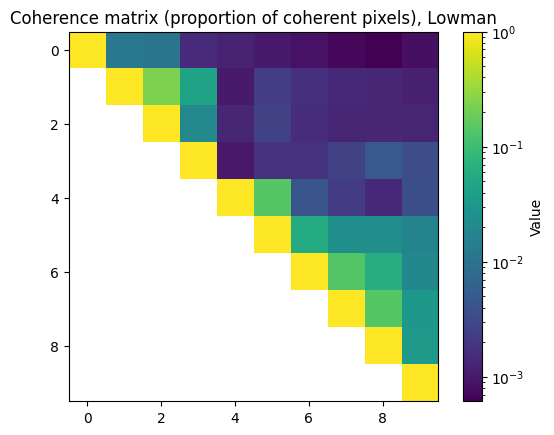

In [13]:
num_coh = np.where(num_coh == 0, np.nan, num_coh)
plt.imshow(num_coh, cmap='viridis', origin='lower', norm=pltcolors.LogNorm()) 
plt.colorbar(label='Value')
plt.title('Coherence matrix (proportion of coherent pixels), Lowman')
plt.gca().invert_yaxis()
# plt.grid(True, color='white', linewidth=0.5)
plt.show()

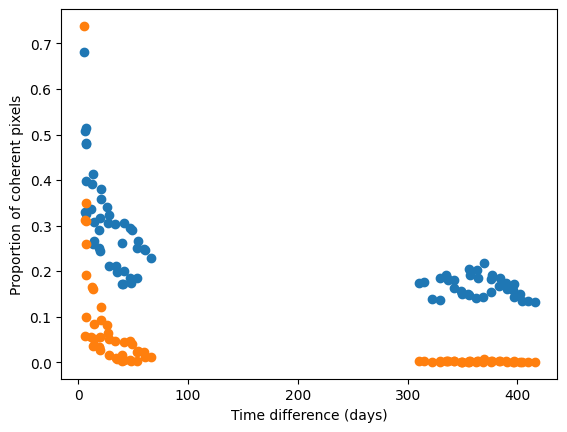

In [26]:
plt.scatter(time_dif, avgs_nan)
plt.scatter(time_dif, num_coh)
plt.xlabel('Time difference (days)')
plt.ylabel('Proportion of coherent pixels')
plt.show()

#### Save the info we just calculated 
Using a numpy format - I just want to be able to start from this later on! 

In [198]:
# print(np.where(avgs != 0))
compiled_info = [time_dif, avgs, num_coh_06, num_coh_03]
np.save(data_dir + 'lowman_23205_pair_info.npy', compiled_info)
np.save(data_dir + 'lowman_23205_dates.npy', dates2)

## Geocoding

I want to geocode the images that I am looking at, to get a sense of where they are in space, and so that I can more easily compare the two flight paths. 

I will geocode the first image of each flight path, which should (?) line up temporally. 

In [ ]:
llh_05208 = slc_dir + "lowman_05208_01_BU_s2_2x8.llh"
print(f"Data dir: {data_dir}")
print(f"Lat/Lon file: {llh_05208}")
print(f"SLC file: {slcs_05208[0]}")
print(f"Annotation file: {anns_05208[0]}")
# print(slcs_05208[0])
# print(slcs_23205[0])
geolocate_uavsar(slcs_05208[0], anns_05208[0], data_dir, llh_05208)

Data dir: ../data/data/snowex_lowman/
Lat/Lon file: ../data/data/snowex_lowman/slcs/lowman_05208_01_BU_s2_2x8.llh
SLC file: ../data/data/snowex_lowman/slcs/lowman_05208_20002_006_200131_L090VV_01_BU_s2_2x8.slc
Annotation file: ../data/data/snowex_lowman/slcs/lowman_05208_20002_006_200131_L090VV_01_BU.ann


/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(
/Users/julo9057/anaconda3/envs/geog6655_coherence/lib/python3.13/site-packages/osgeo/gdal.py:330: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


TypeError: Path.replace() takes 2 positional arguments but 3 were given

: 

## Adding in Snotel data

I downloaded Snotel data for Jackson (550) and Mores Creek Summit (637) for the water years 2020 and 2021. These are stored in csv files with headers 

Site Id,Date,Time,WTEQ.I-1 (in) ,PREC.I-1 (in) ,TOBS.I-1 (degC) ,TMAX.D-1 (degC) ,TMIN.D-1 (degC) ,TAVG.D-1 (degC) ,SNWD.I-1 (in) ,

In [7]:
snotel_dir = "../data/data/snowex_lowman/snotel/"
in_dir = Path(snotel_dir)
snotels = sorted(list(in_dir.glob('*.csv')))
all_snotel = []
for snotel in snotels :
    df = pd.read_csv(snotel, header=1)
    df['Date'] = pd.to_datetime(df['Date'])
    #print(df.columns)
    all_snotel.append(df) 

snotels_df = pd.concat(all_snotel, ignore_index=True)
# print(snotels_df.columns)
snotels_df.columns = ['site_id', 'date', 'time', 'swe_in', 'precip_in', 'obs_temp', 'max_temp', 'min_temp', 'avg_temp', 'sd_in', 'unnamed']

print(snotels_df.head())

   site_id       date time  swe_in  precip_in  obs_temp  max_temp  min_temp  \
0      550 2019-10-01  NaN     0.0        0.0      -3.0       3.7      -6.6   
1      550 2019-10-02  NaN     0.0        0.1      -5.0       1.3      -5.7   
2      550 2019-10-03  NaN     0.0        0.1      -1.0       5.2      -6.7   
3      550 2019-10-04  NaN     0.0        0.1       0.6       9.6      -1.3   
4      550 2019-10-05  NaN     0.0        0.2      -3.8       2.3      -4.1   

   avg_temp  sd_in  unnamed  
0      -2.2    0.0      NaN  
1      -2.4    0.0      NaN  
2      -1.4    0.0      NaN  
3       3.4    0.0      NaN  
4      -1.1    0.0      NaN  


#### Reload other data that we need

To make the scatter plot, we need the coherences, any calculated coherence values, and the time differences. 

In [3]:
data_dir = "../data/data/snowex_lowman/"
coherence_info = np.load(data_dir + 'lowman_23205_pair_info.npy', allow_pickle=True)
# coherence_info = [time_dif, avgs, num_coh_06, num_coh_03]
dates = np.load(data_dir + 'lowman_23205_dates.npy', allow_pickle=True)
# dates5 = np.load(data_dir + 'lowman_05208_dates.npy', allow_pickle=True)

In [4]:
indices = np.where(coherence_info[0] < 200)
print(dates)
# print(dates5)

[Timestamp('2020-01-31 14:30:06-0700', tz='US/Mountain')
 Timestamp('2020-02-13 13:47:36-0700', tz='US/Mountain')
 Timestamp('2020-02-20 18:53:09-0700', tz='US/Mountain')
 Timestamp('2020-03-11 11:45:38-0600', tz='US/Mountain')
 Timestamp('2021-01-15 12:50:41-0700', tz='US/Mountain')
 Timestamp('2021-01-20 14:20:34-0700', tz='US/Mountain')
 Timestamp('2021-01-27 16:54:34-0700', tz='US/Mountain')
 Timestamp('2021-02-03 12:54:53-0700', tz='US/Mountain')
 Timestamp('2021-02-10 15:20:37-0700', tz='US/Mountain')
 Timestamp('2021-03-03 11:08:14-0700', tz='US/Mountain')
 Timestamp('2021-03-10 10:42:49-0700', tz='US/Mountain')
 Timestamp('2021-03-16 11:49:32-0600', tz='US/Mountain')
 Timestamp('2021-03-22 10:39:36-0600', tz='US/Mountain')]


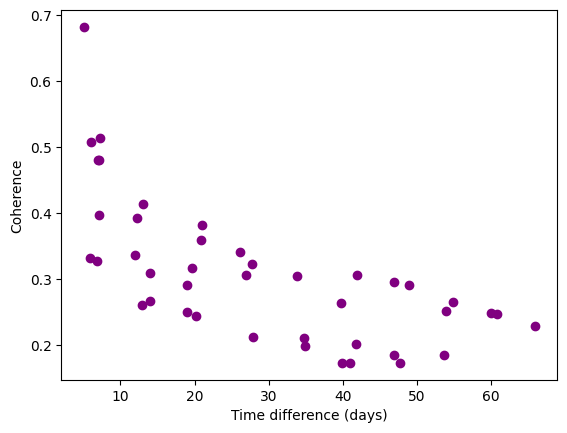

In [5]:
plt.scatter(coherence_info[0][indices], coherence_info[1][indices], c='purple') # average coherence
# plt.scatter(coherence_info[0][indices], coherence_info[3][indices], c='red') # proportion of coherent pixels, threshold = 0.3
plt.xlabel('Time difference (days)')
plt.ylabel('Coherence')
plt.show()

This is the plot that we start with. Ignoring the pairs across different years, we scatter just the average coherences compared to the time difference. We want to 

a) fit a curve to the line and 

b) explore with snotel data a little bit whether there are any possible connections between conditions like precipitation and air temperature 

In [8]:
# divide up the snotels_df by year and station and plot on 4 different subplots
wy_2020_start = pd.to_datetime("2019-10-01")
wy_2020_end = pd.to_datetime("2020-09-01")
wy_2021_start = pd.to_datetime("2020-10-01")
wy_2021_end = pd.to_datetime("2021-09-01")
mores_2020 = snotels_df[(snotels_df['site_id'] == 637) & (snotels_df['date'] >= wy_2020_start) & (snotels_df['date'] <= wy_2020_end)]
mores_2021 = snotels_df[(snotels_df['site_id'] == 637) & (snotels_df['date'] >= wy_2021_start) & (snotels_df['date'] <= wy_2021_end)]
jackson_2020 = snotels_df[(snotels_df['site_id'] == 550) & (snotels_df['date'] >= wy_2020_start) & (snotels_df['date'] <= wy_2020_end)]
jackson_2021 = snotels_df[(snotels_df['site_id'] == 550) & (snotels_df['date'] >= wy_2021_start) & (snotels_df['date'] <= wy_2021_end)]
jackson_2021 = jackson_2021[jackson_2021['avg_temp'].between(-30, 40)]

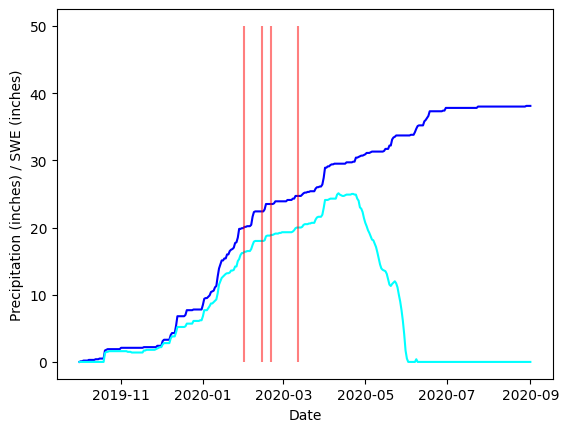

In [205]:
# plt.scatter(dates, c='purple') # average coherence
plt.plot(mores_2020['date'], mores_2020['precip_in'], c='blue') 
plt.plot(jackson_2020['date'], jackson_2020['swe_in'], c = 'cyan')
plt.vlines(x=dates[0:4], ymin=0, ymax=50, linestyles='-', colors='red', alpha=0.5)
# plt.ylim(0, 50)
# plt.scatter(coherence_info[0][indices], coherence_info[3][indices], c='red') # proportion of coherent pixels, threshold = 0.3
plt.xlabel('Date')
plt.ylabel('Precipitation (inches) / SWE (inches)')
plt.show()

2019-10-01 00:00:00 2020-09-01 00:00:00
2020-10-01 00:00:00 2021-09-01 00:00:00
2019-10-01 00:00:00 2020-09-01 00:00:00
2020-10-01 00:00:00 2021-09-01 00:00:00


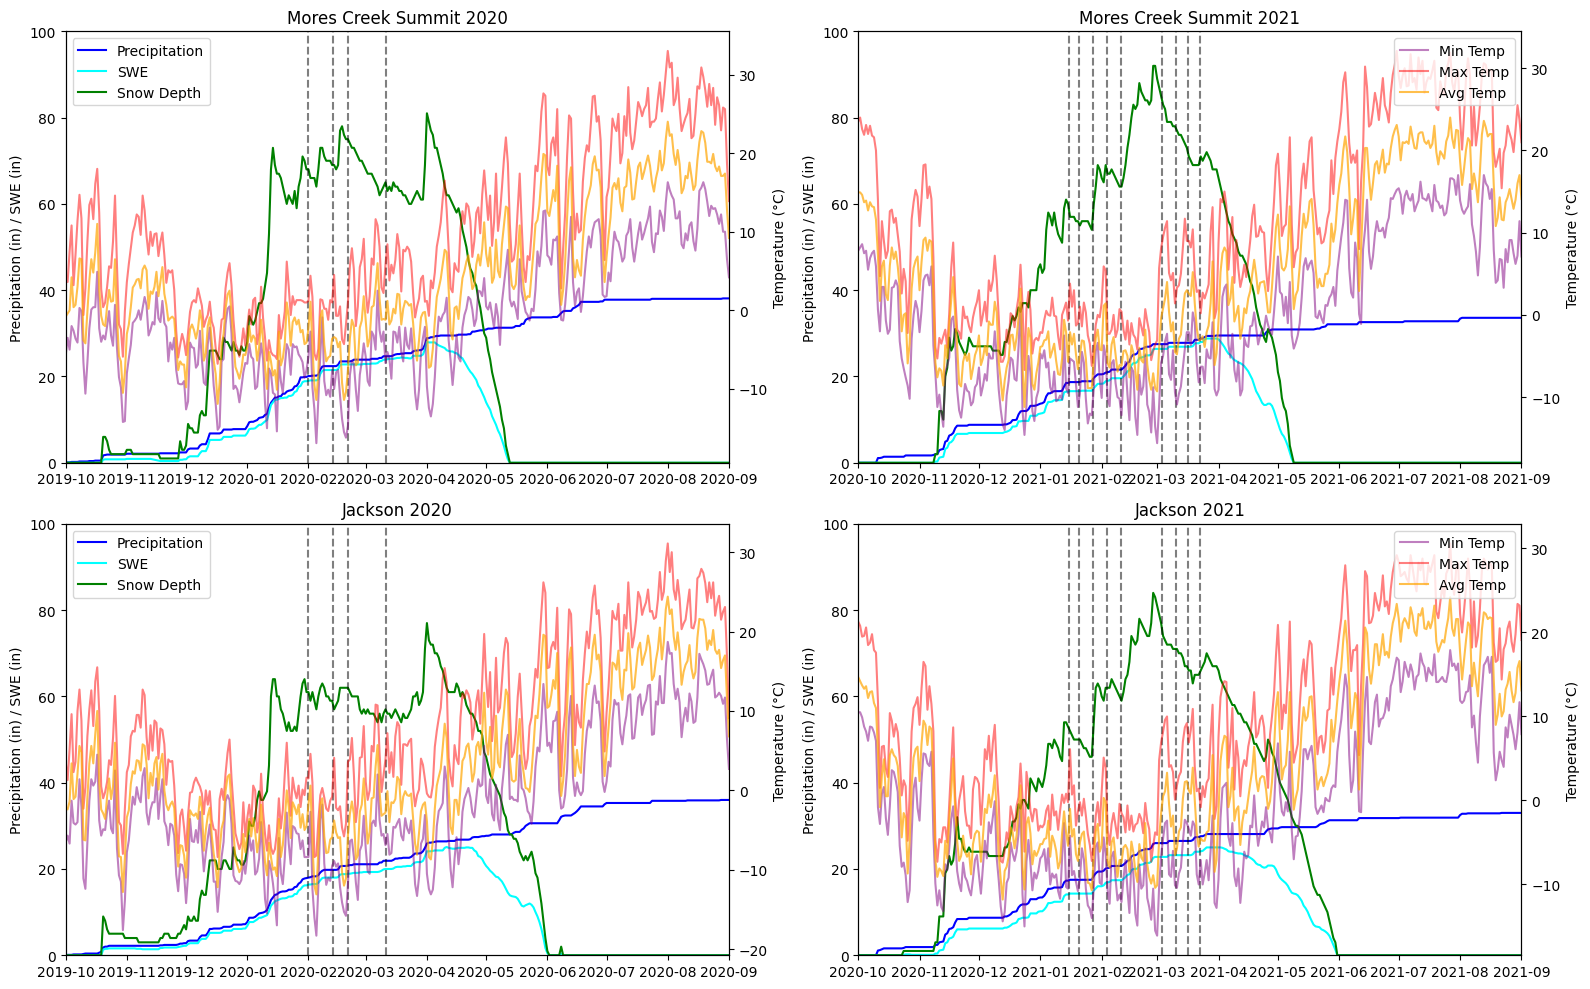

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

data_sets = [
    ("Mores Creek Summit 2020", mores_2020, 0, 0),
    ("Mores Creek Summit 2021", mores_2021, 0, 1),
    ("Jackson 2020", jackson_2020, 1, 0),
    ("Jackson 2021", jackson_2021, 1, 1),
]

for title, df, i, j in data_sets:
    ax = axs[i, j]
    ax2 = ax.twinx()
    ax.plot(df['date'], df['precip_in'], label='Precipitation', color='blue')
    ax.plot(df['date'], df['swe_in'], label='SWE', color='cyan')
    ax.plot(df['date'], df['sd_in'], label='Snow Depth', color='green')
    ax2.plot(df['date'], df['min_temp'], label='Min Temp', color='purple', alpha=0.5)
    ax2.plot(df['date'], df['max_temp'], label='Max Temp', color='red', alpha=0.5)
    ax2.plot(df['date'], df['avg_temp'], label='Avg Temp', color='orange', alpha=0.7)
    # Vertical lines for UAVSAR dates
    start, end = df['date'].min(), df['date'].max()
    print(start, end)
    ax.set_ylabel('Precipitation (in) / SWE (in)')
    ax2.set_ylabel('Temperature (°C)')
    ax.set_title(title)
    for d in dates:
        d_parsed = pd.to_datetime(d).tz_localize(None)  # Remove timezone if present
        if start.tz_localize(None) <= d_parsed <= end.tz_localize(None):
            ax.axvline(x=d_parsed, color='black', linestyle='--', alpha=0.5)
    if j == 0:
        ax.legend(loc='upper left')
    if j == 1:
        ax2.legend(loc='upper right')
    ax.set_ylim(0, 100)
    ax.set_xlim(start, end)

plt.tight_layout()
plt.show()

- Significant snowfal event in 2021 in the longer gap. Expect lower coherence between those. That would be between images 5 and 6. 
- Pretty even spacing between the last 4 images in 2021. 

A next step might be downloading hourly data so we can be more exact with snowfall before/after images were taken. 

#### Calculating some statistics combining SNOTEL with the image pairs

This first big loop calculates a bunch of things that we want to look at with coherence. We take the difference betweeen total SWE and the difference in snow depth from day 1 and day 2. We also calculate an average value for snow depth, average daily temperature, and maximum daily temperature and the sum of all precipitation between the two days. 

In [ ]:
swe_diff = np.full((len(dates), len(dates)), np.nan) 
sd_diff = np.full((len(dates), len(dates)), np.nan)
sd_avg = np.full((len(dates), len(dates)), np.nan)
t_max = np.full((len(dates), len(dates)), np.nan)
t_avg = np.full((len(dates), len(dates)), np.nan)
precip_diff = np.full((len(dates), len(dates)), np.nan)

for i in range(len(dates)) : 
    for j in range(len(dates)) : 
        if (i >= j) : 
            continue
        day1 = pd.to_datetime(dates[i]).date()
        # print(day1)
        day2 = pd.to_datetime(dates[j]).date()

        # calculate the change in SWE between each image pair
        swe1 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day1)) & \
                               (snotels_df['site_id'] == 637)), 'swe_in'].values[0]
        swe2 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day2)) & \
                               (snotels_df['site_id'] == 637)), 'swe_in'].values[0]
        swe_diff[i, j] = (swe2 - swe1) / len(swe_vals)
        swe_vals = snotels_df.loc[((snotels_df['date'] >= pd.to_datetime(day1)) & \
                                (snotels_df['date'] < pd.to_datetime(day2)) & \
                                (snotels_df['site_id'] == 637)), 'swe_in'].values
        swe_diff[i, j] = np.mean(swe_vals) 

        # calculate the change in SWE between each image pair
        pre1 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day1)) & \
                               (snotels_df['site_id'] == 637)), 'precip_in'].values[0]
        pre2 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day2)) & \
                               (snotels_df['site_id'] == 637)), 'precip_in'].values[0]
        precip_diff[i, j] = (pre2 - pre1) / len(swe_vals)

        # calculate the change in snow depth between each image pair
        sd1 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day1)) & \
                              (snotels_df['site_id'] == 637)), 'sd_in'].values[0]
        sd2 = snotels_df.loc[((snotels_df['date'] == pd.to_datetime(day2)) & \
                              (snotels_df['site_id'] == 637)), 'sd_in'].values[0]
        sd_diff[i, j] = sd2 - sd1

        # calculate the average snow depth for the image pair 
        sds = snotels_df.loc[((snotels_df['date'] >= pd.to_datetime(day1)) & \
                              (snotels_df['date'] < pd.to_datetime(day2)) & \
                              (snotels_df['site_id'] == 637)), 'sd_in'].values
        sd_avg[i, j] = np.mean(sds)

        # calculate the average temperature between each image pair 
        t_avgs = snotels_df.loc[((snotels_df['date'] >= pd.to_datetime(day1)) & \
                                 (snotels_df['date'] < pd.to_datetime(day2)) & \
                                 (snotels_df['site_id'] == 637)), 'avg_temp'].values
        t_avg[i, j] = np.mean(t_avgs)

        # calculate the average maximum temperature between each image pair 
        t_maxs = snotels_df.loc[((snotels_df['date'] >= pd.to_datetime(day1)) & \
                                 (snotels_df['date'] < pd.to_datetime(day2)) & \
                                 (snotels_df['site_id'] == 637)), 'max_temp'].values
        t_max[i, j] = np.mean(t_maxs)

        # calculate the total precip between each image pair 
        # precips = snotels_df.loc[((snotels_df['date'] >= pd.to_datetime(day1)) & \
        #                           (snotels_df['date'] < pd.to_datetime(day2)) & \
        #                           (snotels_df['site_id'] == 637)), 'precip_in'].values
        # precip_avg[i, j] = np.mean(precips)
        
# print(swe_diff)
# print(sd_diff)
# print(t_avg)
# print(t_max)
# print(precip_sum)

Here are some scatter plots with the different variables colored. 

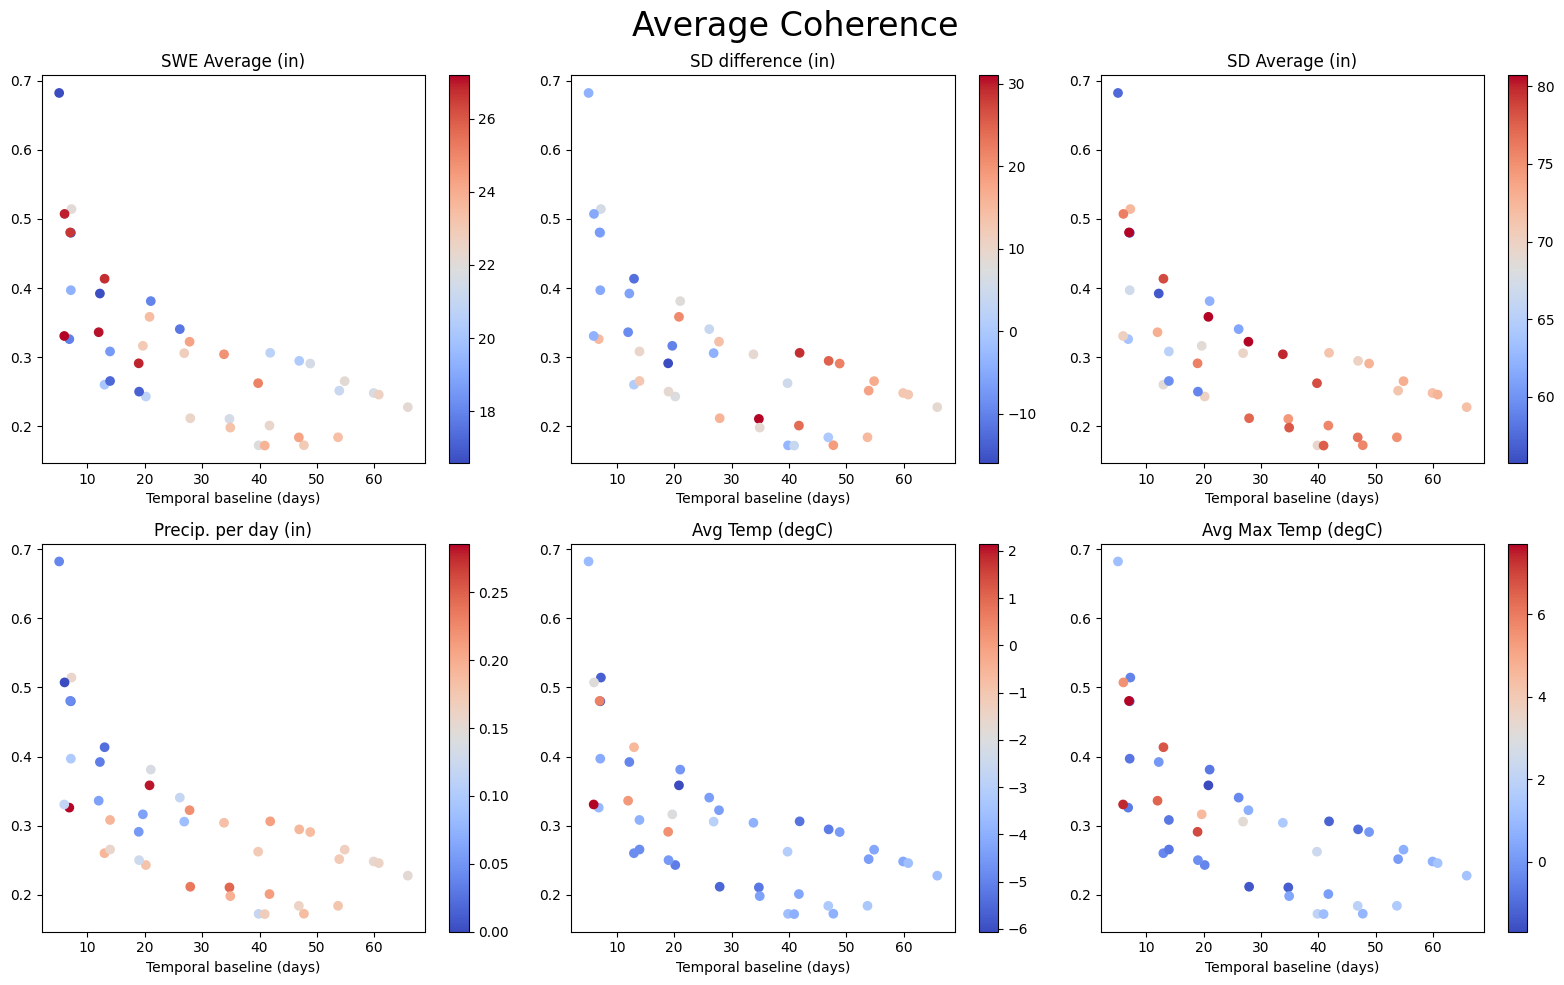

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

data_sets = [
    ("SWE Average (in)", swe_diff, 0, 0),
    ("SD difference (in)", sd_diff, 0, 1),
    ("SD Average (in)", sd_avg, 0, 2),
    ("Precip. per day (in)", precip_diff, 1, 0),
    ("Avg Temp (degC)", t_avg, 1, 1),
    ("Avg Max Temp (degC)", t_max, 1, 2),
]

# coherence_info = [time_dif, avgs, num_coh_06, num_coh_03]
indices = np.where(coherence_info[0] < 200)

for title, df, i, j in data_sets:
    ax = axs[i, j]
    ax.set_xlabel('Temporal baseline (days)')
    ax.set_title(title)
    sc = ax.scatter(coherence_info[0][indices], 
                    coherence_info[1][indices], 
                    c=df[indices],cmap='coolwarm')
    cbar = fig.colorbar(sc, ax=ax)
    # ax.legend(loc='upper right')
fig.suptitle('Average Coherence', fontsize=24)
plt.tight_layout()
plt.show()

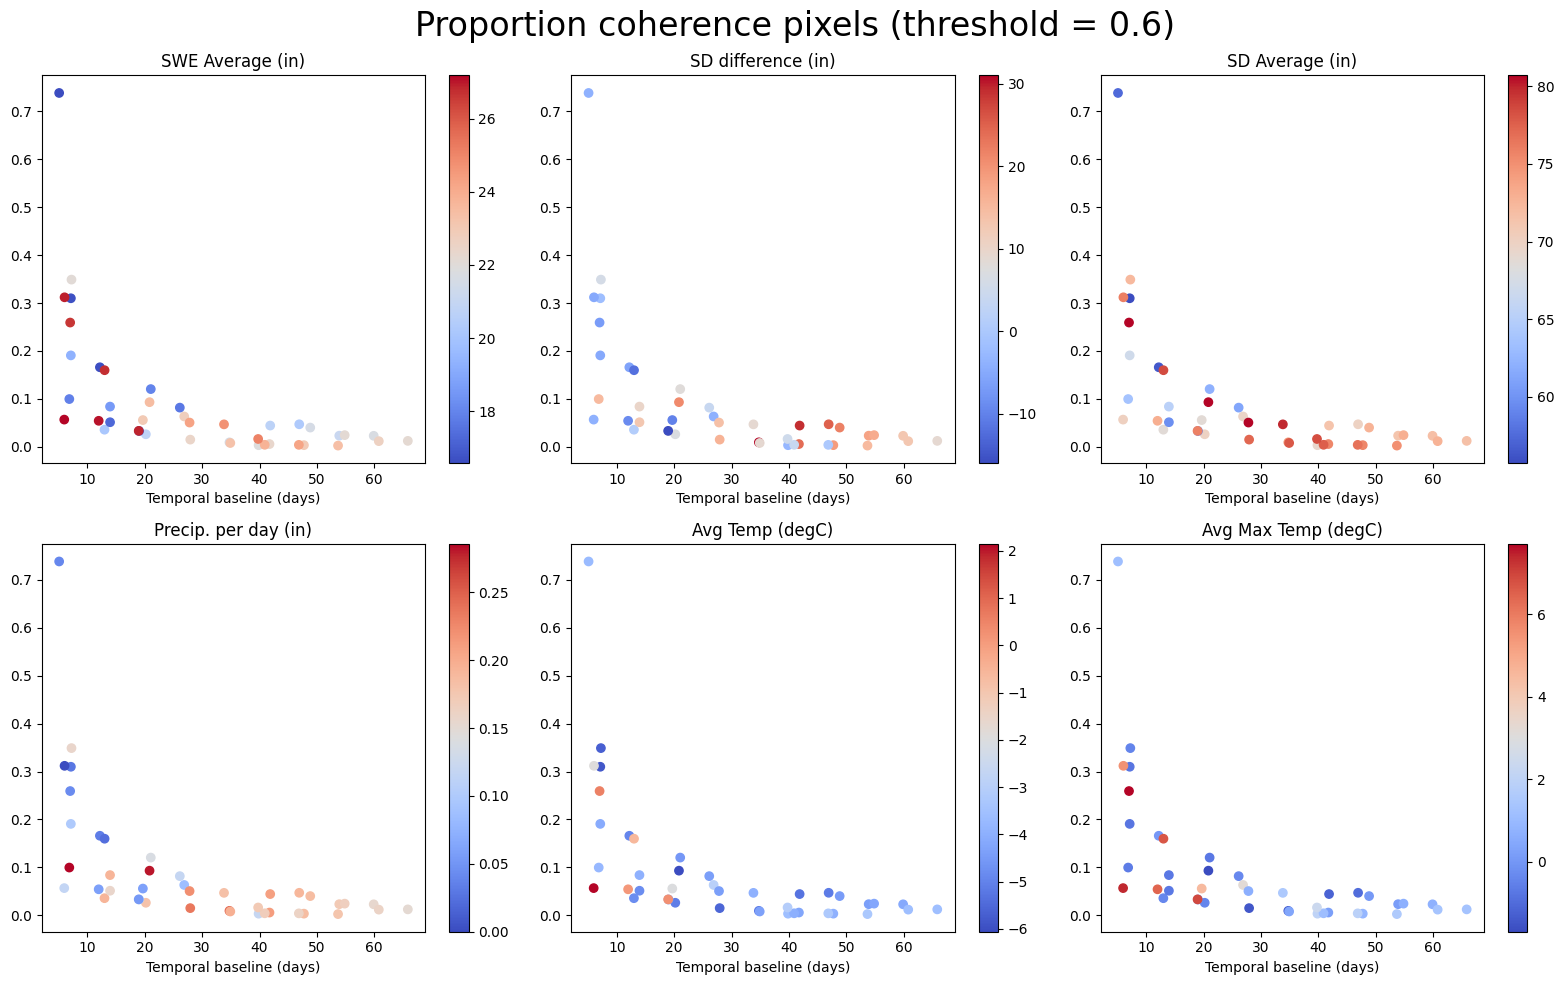

In [14]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for title, df, i, j in data_sets:
    ax = axs[i, j]
    ax.set_xlabel('Temporal baseline (days)')
    ax.set_title(title)
    sc = ax.scatter(coherence_info[0][indices], 
                    coherence_info[2][indices], 
                    c=df[indices],cmap='coolwarm')
    cbar = fig.colorbar(sc, ax=ax)
    # ax.legend(loc='upper right')
fig.suptitle('Proportion coherence pixels (threshold = 0.6)', fontsize=24)
plt.tight_layout()
plt.show()

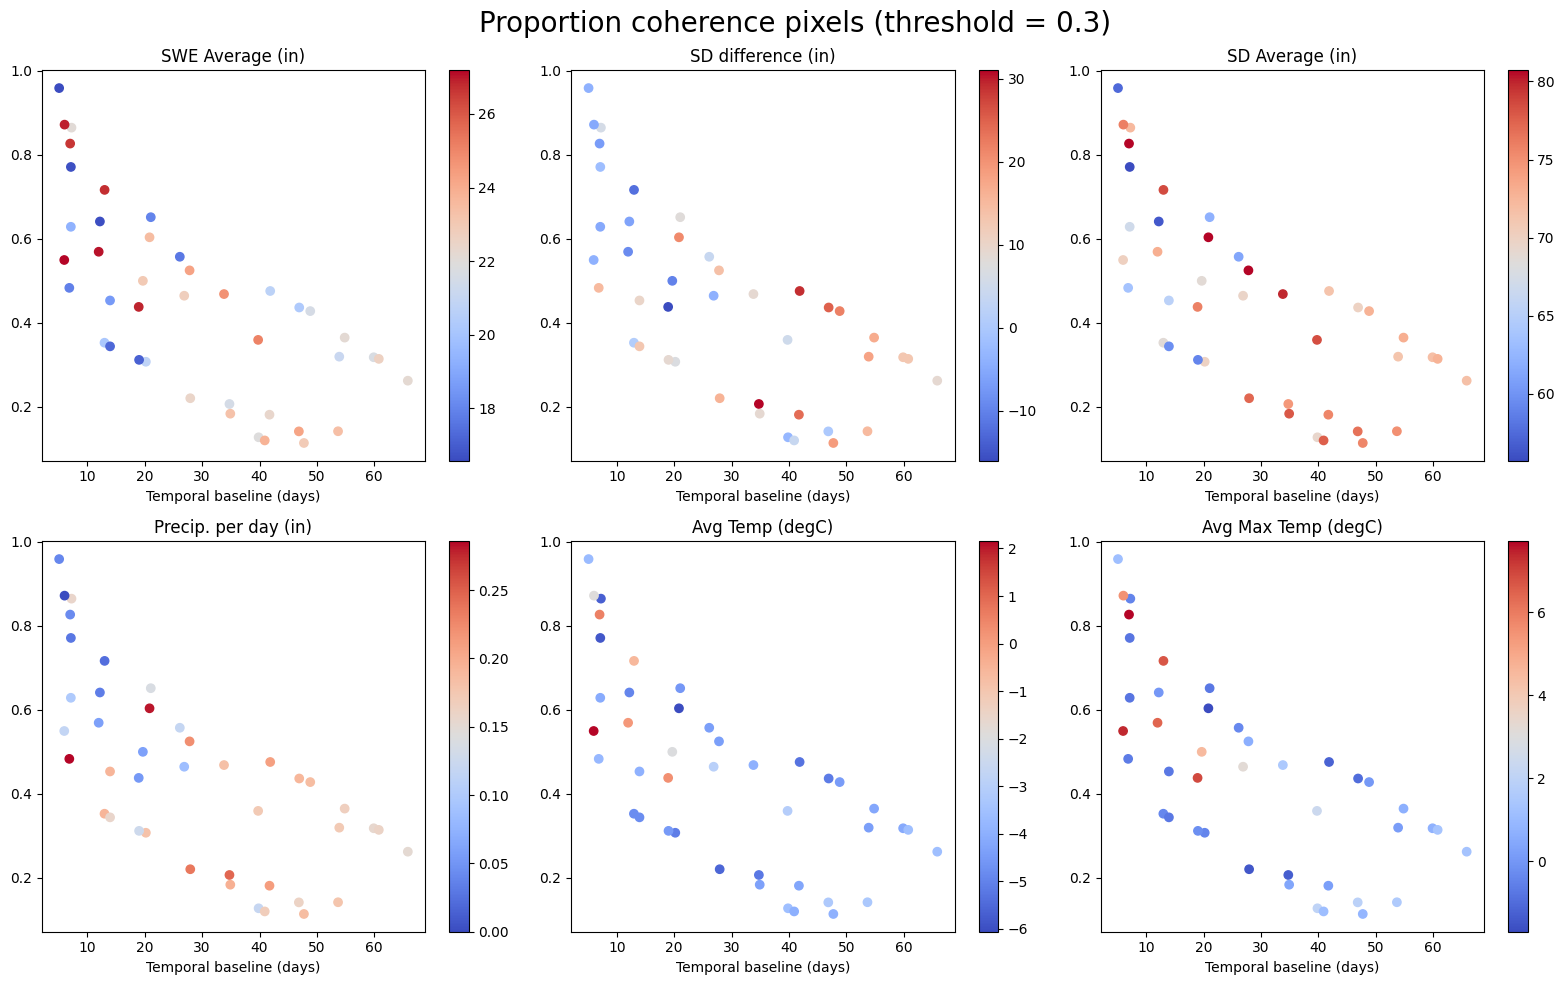

In [15]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for title, df, i, j in data_sets:
    ax = axs[i, j]
    ax.set_xlabel('Temporal baseline (days)')
    ax.set_title(title)
    sc = ax.scatter(coherence_info[0][indices], 
                    coherence_info[3][indices], 
                    c=df[indices],cmap='coolwarm')
    cbar = fig.colorbar(sc, ax=ax)
    # ax.legend(loc='upper right')
fig.suptitle('Proportion coherence pixels (threshold = 0.3)', fontsize=20)
plt.tight_layout()
plt.show()

- Notable that the snowdepth seems to be the only parameter with a clear pattern. Higher snow depth leads to higher coherence. 

### TODO: 
1. Normalize precip and SWE change by day 
2. Figure out what areas to mask out for coherence. 

## Figuring out a mask for coherence. 

Zach thinks we should mask out areas where coherence is lost due to other factors to investigate the effect of the atmospheric factors. 

A couple of figures that might help: 
- Coherence > 0.4 for image pairs that are far apart in time (but still in the same year)
- Coherence > 0.4 for image pairs that are medium apart in time 
- Coherence vs. incidence angle scatter plot. 
- Coherence vs. elevation (as a proxy for vegetation)

In [3]:
# load the data we need
data_dir = "../data/data/snowex_lowman/"
coherence_info = np.load(data_dir + 'lowman_05208_pair_info.npy', allow_pickle=True) # [time_dif, avgs, num_coh_06, num_coh_03]
dates = np.load(data_dir + 'lowman_05208_dates.npy', allow_pickle=True) 
coherences = tif.imread(data_dir + 'lowman_05208_coherences.stack')

In [9]:
rows = coherences.shape[1]
cols = coherences.shape[2]
look_vectors = np.fromfile(data_dir + 'slcs/lowman_05208_01_BU_s2_2x8.lkv', '<c8')
print(look_vectors.shape)
look_vectors = look_vectors.reshape(3, rows, cols)

(61197552,)


ValueError: cannot reshape array of size 61197552 into shape (3,8333,4896)